In [1]:
import math

import tensorflow as tf
import tensorflow.compat.v1 as tfv1

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence

from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import time

import os

from IPython.display import display

import matplotlib.pyplot as plt

df = pd.read_csv("universe_dataset.csv")
df.head()

,txn_date,gross_amount,gross_cost,margin,tax_amount
0,2020-05-19,391.5,0.0,391.5,10.5
1,2020-06-19,365.0,125.0,240.0,22.0
2,2020-06-26,156.0,81.0,75.0,0.0
3,2020-07-16,75.0,0.0,75.0,0.0
4,2020-07-17,786.6,125.0,661.6,44.4


In [2]:
%%time

df['txn_date'] = pd.to_datetime(df['txn_date'])

df = df.loc[:, ["txn_date", "gross_amount"]]
df.sort_values('txn_date', inplace=True, ascending=True)
df = df.reset_index(drop=True)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df['txn_date'].min())
print('The time series ends on: ', df['txn_date'].max())
print("\n")

Number of rows and columns after removing missing values: (18, 2)
The time series starts from:  2020-05-19 00:00:00
The time series ends on:  2020-09-03 00:00:00


CPU times: user 9.76 ms, sys: 178 µs, total: 9.94 ms
Wall time: 48.6 ms


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   txn_date      18 non-null     datetime64[ns]
 1   gross_amount  18 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 416.0 bytes


In [4]:

# Split into training, validation and test datasets.
# Since it's timeseries we should do it by date.
test_cutoff_date = df['txn_date'].max() - timedelta(days=7)
val_cutoff_date = test_cutoff_date - timedelta(days=14)

df_test = df[df['txn_date'] > test_cutoff_date]
df_val = df[(df['txn_date'] > val_cutoff_date) & (df['txn_date'] <= test_cutoff_date)]
df_train = df[df['txn_date'] <= val_cutoff_date]

#check out the datasets
print('Test dates: {} to {}'.format(df_test['txn_date'].min(), df_test['txn_date'].max()))
print('Validation dates: {} to {}'.format(df_val['txn_date'].min(), df_val['txn_date'].max()))
print('Train dates: {} to {}'.format(df_train['txn_date'].min(), df_train['txn_date'].max()))

Test dates: 2020-08-29 00:00:00 to 2020-09-03 00:00:00
Validation dates: 2020-08-18 00:00:00 to 2020-08-25 00:00:00
Train dates: 2020-05-19 00:00:00 to 2020-08-12 00:00:00


In [5]:
df_train.shape, df_test.shape, df_val.shape

((8, 2), (6, 2), (4, 2))

In [6]:
# %%time
# Goal of the model:
#  Predict Global_active_power at a specified time in the future.
#   Eg. We want to predict how much Global_active_power will be ten minutes from now.
#       We can use all the values from t-1, t-2, t-3, .... t-history_length to predict t+10

def create_ts_files(dataset, start_index, end_index, history_length, step_size, target_step, num_rows_per_file, data_folder):
    assert step_size > 0
    assert start_index >= 0
    
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
        
    time_lags = sorted(range(target_step + 1, target_step + history_length + 1, step_size), reverse=True)
    col_names = [f"x_lag_{i}" for i in time_lags] + ["y"]
    
    start_index = start_index + history_length
    
    if end_index is None:
        end_index = len(dataset) - target_step
        
    rng = range(start_index, end_index)
    num_rows = len(rng)
    num_files = math.ceil(num_rows / num_rows_per_file)
    
    # for each file.
    print(f'Creating {num_files} files.')
    
    for i in range(num_files):
        filename = f"{data_folder}/ts_file_{i}.pkl"
        
        if i % 2 == 0:
            print(f"{filename}")
            
        # get the start and end index
        ind0 = i * num_rows_per_file
        ind1 = min(ind0 + num_rows_per_file, end_index)
        
        data_list = []
        
        # j in the current timestep. Will need j-n to j-1 for the history. And j + target_step for the target.
        for j in range(ind0, ind1):
            indices = range(j - 1,  j-history_length - 1, -step_size)
            data = dataset[sorted(indices) + [j + target_step]]
            
            # append data to the list
            data_list.append(data)
            
        df_ts = pd.DataFrame(data_list, columns=col_names)     
        display(df_ts)
        df_ts.to_pickle(filename)
        
    return len(col_names) - 1
            
            
    
    
    
    
batch_size = 60 # 2 months data per_file.
gross_amount = df_train['gross_amount'].values

# Scaled to work with Neural networks.
scaler = MinMaxScaler(feature_range=(0, 1))
gross_amount_scaled = scaler.fit_transform(gross_amount.reshape(-1, 1)).reshape(-1, )


history_length = 7 # The history length in days.
step_size = 1 # The sampling rate of the history. Eg. If step_size = 1, then values from every day will be in the history.
                #                                       If step size = 10 then values every 10 days will be in the history.
target_step = 0  # The time step in the future to predict. Eg. If target_step = 0, then predict the next day after the end of the history period.
                  #                                             If target_step = 10 then predict 10 days the next timestep (11 days after the end of history).

# The csv creation returns the number of rows and number of features. We need these values below.
num_timesteps = create_ts_files(gross_amount_scaled, start_index=0, end_index=None, history_length=history_length, step_size=step_size, 
                                target_step=target_step, num_rows_per_file=batch_size*1, data_folder='ts_data')



Creating 1 files.
ts_data/ts_file_0.pkl


,x_lag_7,x_lag_6,x_lag_5,x_lag_4,x_lag_3,x_lag_2,x_lag_1,y
0,0.322222,0.090000,0.000000,0.790667,0.005111,1.000000,0.472222,0.351667
1,0.090000,0.000000,0.790667,0.005111,1.000000,0.472222,0.351667,0.322222
2,0.000000,0.790667,0.005111,1.000000,0.472222,0.351667,0.322222,0.090000
3,0.790667,0.005111,1.000000,0.472222,0.351667,0.322222,0.090000,0.000000
4,0.005111,1.000000,0.472222,0.351667,0.322222,0.090000,0.000000,0.790667
5,1.000000,0.472222,0.351667,0.322222,0.090000,0.000000,0.790667,0.005111
6,0.472222,0.351667,0.322222,0.090000,0.000000,0.790667,0.005111,1.000000
7,0.351667,0.322222,0.090000,0.000000,0.790667,0.005111,1.000000,0.472222


In [7]:
#
# So we can handle loading the data in chunks from the hard drive instead of having to load everything into memory.
# 
# The reason we want to do this is so we can do custom processing on the data that we are feeding into the LSTM.
# LSTM requires a certain shape and it is tricky to get it right.
#

class TimeSeriesLoader:
    def __init__(self, ts_folder, filename_format):
        self.ts_folder = ts_folder
        
        # find the number of files
        i = 0
        file_found = True
        
        while file_found:
            filename = self.ts_folder + "/" + filename_format.format(i)
            file_found = os.path.exists(filename)
                       
            if file_found:
                i += 1
        
        self.num_files = i
        self.files_indices = np.arange(self.num_files)
        self.shuffle_chunks()
        
    def num_chunks(self):
        return self.num_files
    
    def get_chunk(self, idx):
        assert (idx >= 0) and (idx < self.num_files)
        
        ind = self.files_indices[idx]
        filename = self.ts_folder + "/" + filename_format.format(ind)
        
        df_ts = pd.read_pickle(filename)
        num_records = len(df_ts.index)
        
        features = df_ts.drop("y", axis=1).values
        target = df_ts["y"].values
        
        # Reshape for input into LSTM. Batch major format.
        features_batchmajor = np.array(features).reshape(num_records, -1 , 1)
        return features_batchmajor, target
    
    
    # this shuffles the order the chunks will be outputted from get_chunk.
    def shuffle_chunks(self):
        np.random.shuffle(self.files_indices) 
            
ts_folder = 'ts_data'
filename_format = 'ts_file_{}.pkl'
tss = TimeSeriesLoader(ts_folder, filename_format)

In [8]:
num_timesteps

7

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


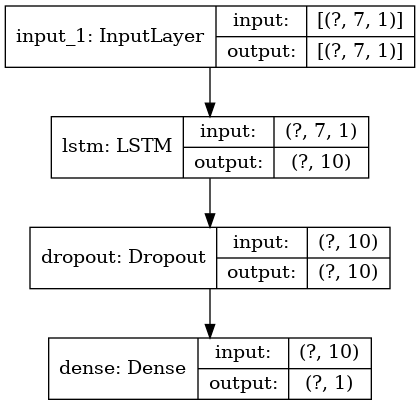

In [9]:
# Create the Keras model.
# Use hyperparameter optimization if you have the time.

ts_inputs = tf.keras.Input(shape=(num_timesteps, 1))

# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)

x = layers.LSTM(units=10)(ts_inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

model.summary()
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [10]:
# Specify the training configuration.
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [11]:
%%time

# train in batch sizes of 128.
BATCH_SIZE = batch_size
NUM_EPOCHS = 500
NUM_CHUNKS = tss.num_chunks()

for epoch in range(NUM_EPOCHS):
    print('epoch #{}'.format(epoch))
    for i in range(NUM_CHUNKS):
        X, y = tss.get_chunk(i)
        
        # model.fit does train the model incrementally. ie. Can call multiple times in batches.
        # https://github.com/keras-team/keras/issues/4446
        history = model.fit(x=X, y=y, batch_size=BATCH_SIZE)
        
    # shuffle the chunks so they're not in the same order next time around.
    tss.shuffle_chunks()

epoch #0
1/1 [==============================] - 0s 1ms/step - loss: 0.4074 - mse: 0.4074
epoch #1
1/1 [==============================] - 0s 2ms/step - loss: 0.4178 - mse: 0.4178
epoch #2
1/1 [==============================] - 0s 1ms/step - loss: 0.3397 - mse: 0.3397
epoch #3
1/1 [==============================] - 0s 1ms/step - loss: 0.2880 - mse: 0.2880
epoch #4
1/1 [==============================] - 0s 4ms/step - loss: 0.2764 - mse: 0.2764
epoch #5
1/1 [==============================] - 0s 2ms/step - loss: 0.2498 - mse: 0.2498
epoch #6
1/1 [==============================] - 0s 4ms/step - loss: 0.3072 - mse: 0.3072
epoch #7
1/1 [==============================] - 0s 4ms/step - loss: 0.2315 - mse: 0.2315
epoch #8
1/1 [==============================] - 0s 3ms/step - loss: 0.2302 - mse: 0.2302
epoch #9
1/1 [==============================] - 0s 4ms/step - loss: 0.2245 - mse: 0.2245
epoch #10
1/1 [==============================] - 0s 4ms/step - loss: 0.2134 - mse: 0.2134
epoch #11
1/1 [=====

In [14]:
history.history

{'loss': [0.0908333882689476], 'mse': [0.0908333882689476]}

In [23]:
# evaluate the model on the validation set.
#
# Create the validation CSV like we did before with the training.
gross_amount_val = df_val['gross_amount'].values
gross_amount_val_scaled = scaler.transform(gross_amount_val.reshape(-1, 1)).reshape(-1, )

display(gross_amount_val_scaled.shape)

history_length = 3  # The history length in minutes.
step_size = 1  # The sampling rate of the history. Eg. If step_size = 1, then values from every minute will be in the history.
                #                                       If step size = 10 then values every 10 minutes will be in the history.
target_step = 0  # The time step in the future to predict. Eg. If target_step = 0, then predict the next timestep after the end of the history period.
#                   #                                             If target_step = 10 then predict 10 timesteps the next timestep (11 minutes after the end of history).

# The csv creation returns the number of rows and number of features. We need these values below.
num_timesteps = create_ts_files(gross_amount_val_scaled, start_index=0, end_index=None, history_length=history_length, step_size=step_size, 
                                target_step=target_step, num_rows_per_file=batch_size*1, data_folder='ts_val_data')

num_timesteps

(4,)

Creating 1 files.
ts_val_data/ts_file_0.pkl


3

In [25]:
# If we assume that the validation dataset can fit into memory we can do this.
df_val_ts = pd.read_pickle('ts_val_data/ts_file_0.pkl')


features = df_val_ts.drop('y', axis=1).values
features_arr = np.array(features)

# reshape for input into LSTM. Batch major format.
num_records = len(df_val_ts.index)
features_batchmajor = features_arr.reshape(num_records, -1, 1)

print(features_batchmajor.shape)


y_pred = model.predict(features_batchmajor).reshape(-1, )
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1, )

y_act = df_val_ts['y'].values
y_act = scaler.inverse_transform(y_act.reshape(-1, 1)).reshape(-1, )

print('validation mean squared error: {}'.format(mean_squared_error(y_act, y_pred)))

print(df_val_ts)

#baseline
# y_pred_baseline = df_val_ts['x_lag11'].values
# y_pred_baseline = scaler.inverse_transform(y_pred_baseline.reshape(-1, 1)).reshape(-1 ,)
# print('validation baseline mean squared error: {}'.format(mean_squared_error(y_act, y_pred_baseline)))


(4, 3, 1)
validation mean squared error: 146517.85518546263
    x_lag_3   x_lag_2   x_lag_1         y
0  0.222222  0.000000  0.005556  0.005556
1  0.000000  0.005556  0.005556  0.222222
2  0.005556  0.005556  0.222222  0.000000
3  0.005556  0.222222  0.000000  0.005556


In [26]:
keras.backend.clear_session()